# Importamos todas las dependencias necesarias para poder hacer modelo sin ningun problema

Identificar un problema de clasificación de imagenes que puedan resolver utilizando una red neuronal convolucional implementada en Keras utilizando TensorFlow como vimos en clase Desarrollar un modelo para resolver en un Python Notebook, donde diseñen una red e implementen como adaptar los datos de entrada a una matriz, para pasarla por un modelo creado con Keras. Ademas en el mismo notebook deberán:

Explicar el problema a resolver y la solución propuesta
Identificar y explicar los conceptos teóricos vistos en clase sobre modelado y entrenamiento de redes neuronales. Tip: visualizar el modelo con algún paquete como keras-visualizer para explicar su comportamiento.
Visualizar los datos de entrada, ejemplos tomados del dataset, y algunos ejemplos de salida.
Se puede optar por resolver el problema con el dataset de Fashion MNIST. Este ya viene cargado en Google Colab. Pueden encontrar otros datasets en Kaggle o directamente de internet.

El trabajo se puede resolver de hasta 4 integrantes.

Dataset

- https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow.keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path
import os
import cv2
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

# Importamos tambien las imagenes que vamos a utilizar y separamos la imagen en si, y sus caracteristicas (nombre del personaje)

In [4]:
directorio = Path('../input/the-simpsons-characters-dataset/simpsons_dataset')

extension_de_archivo = list(directorio.glob(r'**/*.jpg'))

caracteristicas = []
imagenes = []

image_size = 64

for file in extension_de_archivo:
    head = os.path.split(file)
    character = os.path.split(head[0])
    caracteristicas.append(character[1])
    img = cv2.imread(str(file))
    img = cv2.resize(img, (image_size, image_size)).astype('float32') / 255.0
    imagenes.append(img)

imagenes = np.array(imagenes)
caracteristicas = np.array(caracteristicas)

Hacemos un dataframe con los datos

In [5]:
pd_archivo = pd.Series(extension_de_archivo, name='Archivo').astype(str)

pd_carac = pd.Series(caracteristicas, name='Caracteristicas')

df = pd.concat([pd_archivo, pd_carac], axis=1)

df = df.sample(frac=1).reset_index(drop = True)

df_singles = df.copy().drop_duplicates(subset=('Archivo')).reset_index()

num_classes = df_singles.shape[0]

El dataframe se basa en una coleccion de imagenes de los diferentes personajes de los simpsons, ya sea Homero, Bart, Lisa entre otros

In [6]:
x_train, x_test, y_train, y_test = train_test_split(imagenes, caracteristicas, test_size=0.2, random_state=44)

In [7]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

y_train_tf = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test_tf = tensorflow.keras.utils.to_categorical(y_test, num_classes)

# Como ya separamos todos los datos, entre los de prueba y los de entrenamiento ahora configuramos los pesos y los valores de entrenamiento

Como el dataset de imagenes ya venia con los pesos decidimos utilizarlos. Intentamos utilizar Tensorflow pero no sabiamos como y por temas de tiempo terminamos utilizando copy_file

In [8]:
from distutils.file_util import copy_file

fromDirectory = '../input/the-simpsons-characters-dataset/weights.best.hdf5'
toDirectory = 'weights.best.hdf5'
copy_file(fromDirectory,toDirectory)

checkpointer = ModelCheckpoint(filepath="weights.best.hdf5", verbose=0, save_best_only=True)

input_shape = (image_size, image_size, 3)

learning_rate = 0.001
weight_decay = 1e-4

# Creamos la secuencia para entrenar al modelo

In [9]:
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape)) 
model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

In [10]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=1, mode='auto')

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=['accuracy'])
model.save('./simpsons.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        2688      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 96)        83040     
                                                                 
 batch_normalization (Batch  (None, 60, 60, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 96)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 96)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       1

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=10, batch_size=1000, shuffle=True) 

Epoch 1/10
27/27 [==============================] - 998s 37s/step - loss: 4.4966 - accuracy: 0.1511 - val_loss: 8.9940 - val_accuracy: 0.1475
Epoch 2/10
27/27 [==============================] - 1050s 39s/step - loss: 2.8470 - accuracy: 0.4019 - val_loss: 5.0314 - val_accuracy: 0.0739
Epoch 3/10
27/27 [==============================] - 1036s 39s/step - loss: 2.2311 - accuracy: 0.5505 - val_loss: 3.8989 - val_accuracy: 0.0987
Epoch 4/10
27/27 [==============================] - 977s 36s/step - loss: 1.8075 - accuracy: 0.6472 - val_loss: 3.9599 - val_accuracy: 0.0688
Epoch 5/10
27/27 [==============================] - 960s 36s/step - loss: 1.5193 - accuracy: 0.7156 - val_loss: 3.7199 - val_accuracy: 0.1088
Epoch 6/10
27/27 [==============================] - 967s 36s/step - loss: 1.2971 - accuracy: 0.7628 - val_loss: 3.9913 - val_accuracy: 0.1084
Epoch 7/10
27/27 [==============================] - 971s 36s/step - loss: 1.1462 - accuracy: 0.7988 - val_loss: 4.1352 - val_accuracy: 0.1091
Epoc

# Perdida durante el entrenamiento

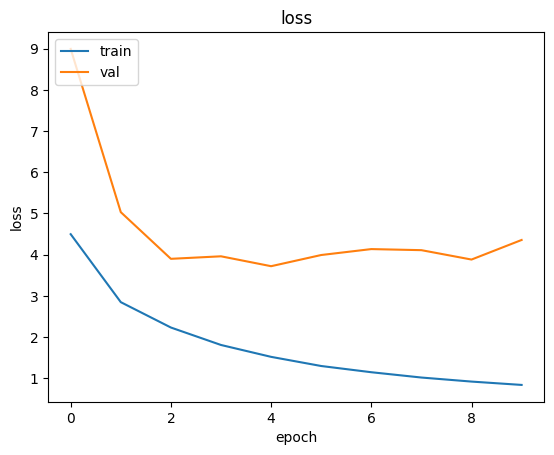

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Acierto durante el entrenamiento

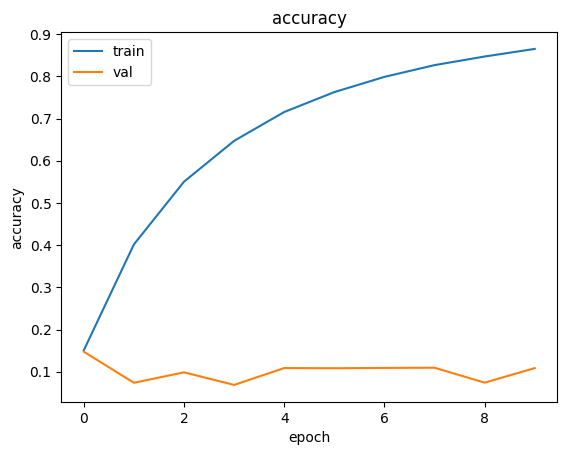

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Conclusion

Como equipo, podemos decir que a traves de todo el año hemos aprendido muchos temas que no teniamos ni la mas palida idea realmente. Para empezar por lo mas basico, ninguno de nosotros tenia idea de que era un vector, y hoy en dia podemos decir hasta que son los tensores. Para continuar, vimos diferentes modelos como los de regresion linear entre otros como los arboles de decisiones. Luego, tambien vimos redes neuronales las cuales nos complicaron un poco la vida la verdad, pero finalmente logramos entenderlas algo. Por ultimo, vimos los CNN, las Convolutional Neural Network, las cuales utilizamos para clasificar imagenes. En este TP final, nosotros nos propusimos resolver un problema de categorizacion de personajes de la serie "Los Simpsons". Utilizamos los conceptos vistos en clase como el MaxPooling, el Flatten entre otros.

# - Max Pooling

El maxPooling es una tecnica que se utiliza a la hora de entrenar redes neuronales convolucionales ya que esta misma se basa en reducir el tamaño del input pero manteniendo la información más importante y eliminando mas menos importante

# - Flatten

Este mismo se utiliza para convertir las capas de salida, o sea los outputs de las capas que contienen caracteristicas bidimencionales, para luego convertirlas en unidimencionales. Todo esto, ya que cuando se pasa de capas convolucionales a capas normales, se necesitan datos unidimencionales

# - Conv2D

El Conv2D es un metodo de tensorflow el cual se utiliza para agregarle KERNELS a la capas de entrada bidimensionales, o sea, imagenes entre otros tipos de inputs. Estos KERNELS o Filtros buscan encontrar patrones para poder categorizar luego los diferentes tipos de imagenes dadas. Aqui hay una demostracion de lo que seria un KERNEL, basicamente:

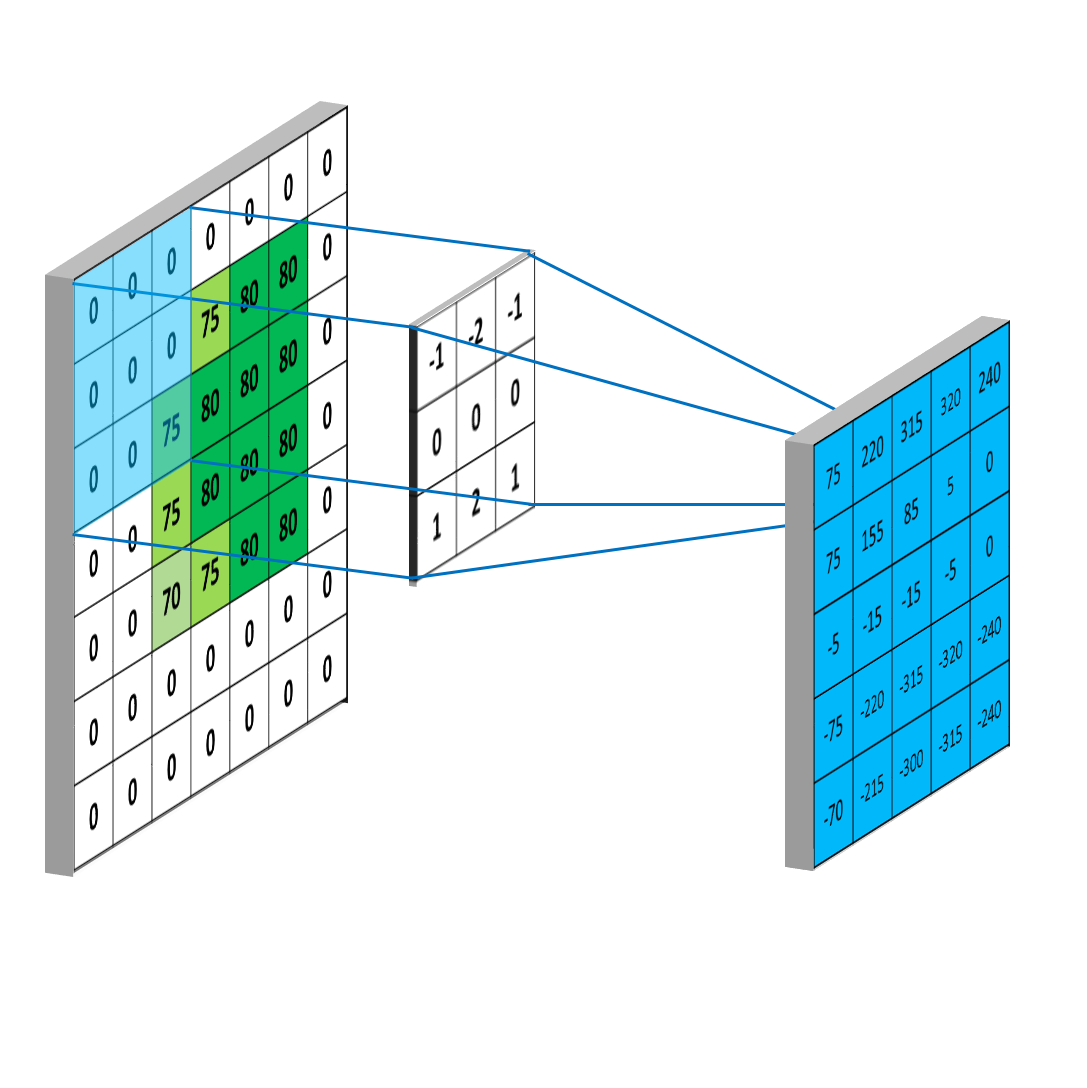

Finalmente, queriamos aclarar que nuestro modelo no funciona a la perfeccion, nos quedo un poco mal y la verdad tuvo mucho LOSS durante el entrenamiento, el problema es que cuando lo entrenabamos con mas EPOCHS las computadoras tardaban muchisimas horas en realizarlo y por temas de tiempo con las diferentes materias no pudimos realizarlo como queriamos realmente. Esperamos que eso sea comprendido, y muchas gracias Chona por el año de aprendizaje que nos diste.

# PD: Perdon por la entrega tardia, no sabiamos que la entrega era el miercoles pasado